In [1]:
import gurobipy as gp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time

%matplotlib inline

from markowitz import Markowitz

In [2]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

### Leitura dos dados de entrada:

In [3]:
df = pd.read_excel('seriehistorica.xlsx', index_col = 0)
df.fillna(method='ffill',inplace=True)

pf = pd.read_excel('perfilfundos.xlsx', usecols = ['CNPJ', 'APLICACAO_MINIMA', 'CATEGORIA', 'SUBCATEGORIA'])
pf['CNPJ'] = pf['CNPJ'].apply(lambda x: re.sub('\W+', '', x))
pf['APLICACAO_MINIMA'] = pd.to_numeric(pf['APLICACAO_MINIMA'].apply(lambda x : re.sub('\D+', '', x)), errors='coerce')
pf.fillna(0, inplace=True)
pf.set_index('CNPJ',inplace=True)

pf_ordered = pf.sort_values(by ='CATEGORIA')
pf_ordered.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)

### Pré-processamento dos dados:

In [4]:
categorias = list(pf_ordered['CATEGORIA'].unique())

limites = [0]

a = 0

for c in categorias:
    a += len(pf_ordered[pf_ordered['CATEGORIA'] == c])
    limites.append(a)

print(limites)

[0, 173, 177, 474, 569]


In [5]:
categorias

['Ações', 'Cambial', 'Multimercados', 'Renda Fixa']

In [6]:
cnpj = list(pf_ordered.index)
df = df[cnpj]

### Parâmetros de entrada do modelo:

In [7]:
df_retorno = df.pct_change().dropna()
sigma = (df_retorno.cov()*252).to_numpy()
media = (df_retorno+1).apply(geo_mean)**252-1

In [8]:
minFundos = np.array(pf_ordered['APLICACAO_MINIMA'])
n = len(minFundos)

In [9]:
minRetorno = 0.20
C = 100000

# CONSERVADOR:
P_categorias = [0.00, 0.00, 0.00, 1.00]
# MODERADO:
#P_categorias = [0.25, 0.00, 0.35, 0.50]
# ARROJADO:
#P_categorias = [0.50, 0.10, 0.35, 0.35]

#P_categorias = [0.25, 0.15, 0.25, 0.35]

K_min = 3
K_max = 10
P_min = 0.05
P_max = 0.3
l = 1
log = 0

### Solução do modelo e visão do resultado:

In [10]:
import time

tempo_init = time.time()
modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
    n, minFundos, sigma, media, cnpj)
print('Tempo para instanciar o modelo:', time.time() - tempo_init, 's')
Carteira = modelo.solve(time = 10)
print('Tempo total do processo:', time.time() - tempo_init, 's')

Carteira.exibir(C)

Academic license - for non-commercial use only - expires 2021-11-05
Using license file C:\Users\Eduardo\gurobi.lic
Tempo para instanciar o modelo: 11.73267126083374 s
Tempo total do processo: 18.304047107696533 s
Retorno esperado --> 20.0%
Risco estimado --> 2.88%
Fundo 44 (14799785000119) --> 8.26%; R$ 8258.72 --> R$ 5000.0
Fundo 63 (29177024000100) --> 6.74%; R$ 6741.28 --> R$ 250.0
Fundo 105 (32102192000133) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 113 (08968733000126) --> 5.0%; R$ 5000.0 --> R$ 250.0
Fundo 173 (20077065000142) --> 15.0%; R$ 15000.0 --> R$ 500.0
Fundo 434 (22652091000182) --> 15.0%; R$ 15000.0 --> R$ 15000.0
Fundo 447 (19959703000170) --> 5.0%; R$ 5000.0 --> R$ 0.0
Fundo 470 (21732619000160) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 521 (31506482000180) --> 7.26%; R$ 7264.86 --> R$ 500.0
Fundo 524 (30934757000113) --> 27.74%; R$ 27735.14 --> R$ 1000.0


In [11]:
modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
    n, minFundos, sigma, media, cnpj, obj_type='classico', l=80, log=0)
Carteira = modelo.solve(time = 10)

Carteira.exibir(C)

Retorno esperado --> 34.86%
Risco estimado --> 4.57%
Fundo 63 (29177024000100) --> 15.37%; R$ 15371.94 --> R$ 250.0
Fundo 113 (08968733000126) --> 9.63%; R$ 9628.06 --> R$ 250.0
Fundo 173 (20077065000142) --> 15.0%; R$ 15000.0 --> R$ 500.0
Fundo 242 (33736873000116) --> 5.0%; R$ 5000.0 --> R$ 500.0
Fundo 447 (19959703000170) --> 5.49%; R$ 5487.2 --> R$ 0.0
Fundo 470 (21732619000160) --> 14.51%; R$ 14512.8 --> R$ 1000.0
Fundo 495 (26664935000166) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 524 (30934757000113) --> 30.0%; R$ 30000.0 --> R$ 1000.0


In [12]:
categoria = np.array(pf['CATEGORIA'][Carteira.descricao])
subcategoria = np.array(pf['SUBCATEGORIA'][Carteira.descricao])

for i in range(len(categoria)):
    print(f"{Carteira.descricao[i]} --> {categoria[i]} --> {subcategoria[i]}")
    

29177024000100 --> Ações --> Ações Dividendos
08968733000126 --> Ações --> Ações Livre
20077065000142 --> Cambial --> Cambial
33736873000116 --> Multimercados --> Multimercados Estratégia Específica
19959703000170 --> Multimercados --> Multimercados Macro
21732619000160 --> Multimercados --> Multimercados Investimento no Exterior
26664935000166 --> Renda Fixa --> Renda Fixa Duração Livre Crédito Livre
30934757000113 --> Renda Fixa --> Renda Fixa Duração Livre Crédito Livre


### Fronteira Eficiente:

In [11]:
modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
    n, minFundos, sigma, media, cnpj)

Academic license - for non-commercial use only - expires 2021-11-05
Using license file C:\Users\Eduardo\gurobi.lic


In [12]:
carteiras, idx_max_sharpe = modelo.solve_fronteira(0.0, 0.2, 0.005, log_sol=1)

minRetorno atual: 0.0
minRetorno atual: 0.005
minRetorno atual: 0.01
minRetorno atual: 0.015
minRetorno atual: 0.02
minRetorno atual: 0.025
minRetorno atual: 0.030000000000000002
minRetorno atual: 0.035
minRetorno atual: 0.04
minRetorno atual: 0.045
minRetorno atual: 0.049999999999999996
minRetorno atual: 0.05499999999999999
minRetorno atual: 0.05999999999999999
minRetorno atual: 0.06499999999999999
minRetorno atual: 0.06999999999999999
minRetorno atual: 0.075
minRetorno atual: 0.08
minRetorno atual: 0.085
minRetorno atual: 0.09000000000000001
minRetorno atual: 0.09500000000000001
minRetorno atual: 0.10000000000000002
minRetorno atual: 0.10500000000000002
minRetorno atual: 0.11000000000000003
minRetorno atual: 0.11500000000000003
minRetorno atual: 0.12000000000000004
minRetorno atual: 0.12500000000000003
minRetorno atual: 0.13000000000000003
minRetorno atual: 0.13500000000000004
minRetorno atual: 0.14000000000000004
minRetorno atual: 0.14500000000000005
minRetorno atual: 0.150000000000

In [14]:
carteiras

[Carteira(Retorno=0.04917008097863951, Risco=0.0012874795965331803, Qtd. de fundos=7,
 fundos=[475, 490, 517, 525, 557, 559, 566], 
 porcentagem=[0.05, 0.3, 0.14299264208494603, 0.07788848808413537, 0.14518937880242522, 0.15305382798977646, 0.13087566303871678], 
 descricao=['22003346000186', '00840011000180', '15174629000125', '31963396000104', '34109809000178', '14237118000142', '30921203000181'], 
 minFundos=[100.0, 3000.0, 1000.0, 100.0, 1000.0, 5000.0, 1000.0],
 Carteira(Retorno=0.04444667177432185, Risco=0.0011347077331414893, Qtd. de fundos=7,
 fundos=[490, 517, 525, 557, 559, 563, 566], 
 porcentagem=[0.3, 0.14299264208494614, 0.04999999999999999, 0.04999999999999999, 0.1530538279897766, 0.17307786688656052, 0.1308756630387168], 
 descricao=['00840011000180', '15174629000125', '31963396000104', '34109809000178', '14237118000142', '35726805000100', '30921203000181'], 
 minFundos=[3000.0, 1000.0, 100.0, 1000.0, 5000.0, 30.0, 1000.0],
 Carteira(Retorno=0.039859140949847466, Risco=

In [16]:
for cart in carteiras:
    print( (cart.Retorno - 0.0525)/cart.Risco )

-2.586385858328958
-7.097270945164133
-12.1168157092117
-12.1168157092117
-11.977329271986575
-1.9259479882826933
4.633486736676605
8.27533592033371
7.293806387291243
2.5083699541746047
2.294083998078299
1.8756016406140787
1.5827241355498218
1.4129509781345255
1.3042017597145346
1.2266283402258855
1.1669855400079565
1.1186466607511332
1.079088810605778


<Figure size 432x288 with 0 Axes>

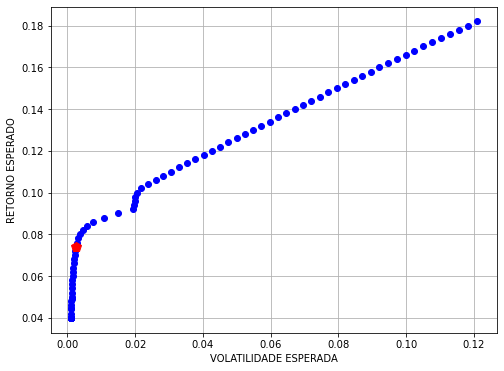

In [23]:
fig = plt.figure() 
plt.figure(figsize=(8,6))
plt.plot([cart.Risco for cart in carteiras], [cart.Retorno for cart in carteiras], 'ob')
plt.plot(carteiras[idx_max_sharpe].Risco, carteiras[idx_max_sharpe].Retorno, 'pr', markersize='11')
#plt.ylim((0,1.25))
#plt.xlim((-0.01,0.7))
plt.grid()
plt.xlabel('VOLATILIDADE ESPERADA')
plt.ylabel('RETORNO ESPERADO')
#plt.savefig('conservador.pdf')
plt.show()

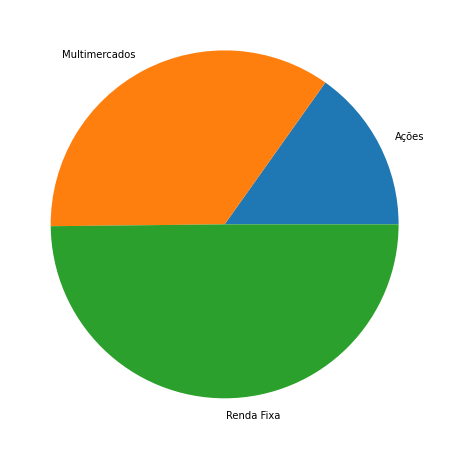

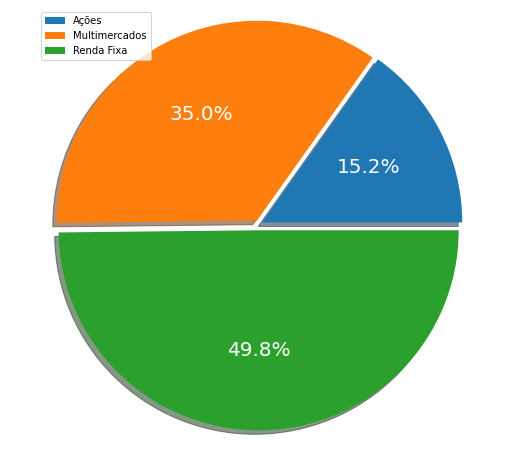

In [56]:
from matplotlib import pyplot as plt
%matplotlib inline

lista_1 = [
    '29177024000100', '08968733000126', '33736873000116', '31964074000171', '22652091000182',
    '21732619000160', '32102131000176', '26759909000111', '26664935000166', '30934757000113'
]

valores = [15.17, 35, 49.83]
#valores_1 = [15.17, 0, 35, 49.83]
labels_dados = ['Ações', 'Multimercados', 'Renda Fixa']

plt.figure(figsize=(8,8))
plt.pie(valores, labels = labels_dados)
#plt.savefig('moderado_pie_1.pdf')
plt.show()

explode_dados = (0.02, 0.02, 0.03)
plt.figure(figsize=(8,8))
plt.pie(valores, 
        autopct = '%1.1f%%', textprops = {'color':'w', 'fontsize': 20},
        labels=labels_dados, shadow=True, explode=explode_dados
       )
plt.legend(labels_dados, loc=2)
plt.axis('equal')
#plt.savefig('moderado_pie_2.pdf')
plt.show()


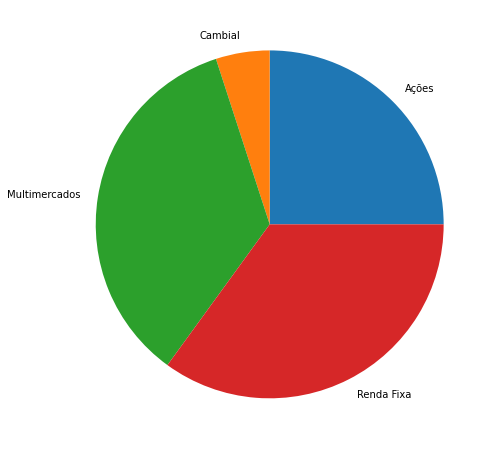

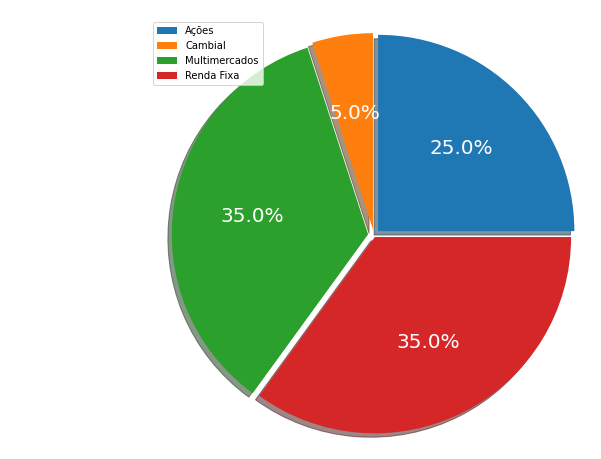

In [57]:
from matplotlib import pyplot as plt
%matplotlib inline

lista_2 = [
    '29177024000100', '08968733000126', '20077065000142', '33736873000116', '31964074000171',
    '19959703000170', '21732619000160', '26664935000166', '30934757000113'
]

valores = [25, 5, 35, 35]
#valores_2 = [15.17, 0, 35, 49.83]
labels_dados = ['Ações', 'Cambial', 'Multimercados', 'Renda Fixa']

plt.figure(figsize=(8,8))
plt.pie(valores, labels = labels_dados)
#plt.savefig('arrojado_pie_1.pdf')
plt.show()

explode_dados = (0.03, 0.03, 0.03, 0.01)
plt.figure(figsize=(8,8))
plt.pie(valores, 
        autopct = '%1.1f%%', textprops = {'color':'w', 'fontsize': 20},
        labels=labels_dados, shadow=True, explode=explode_dados
       )
plt.legend(labels_dados, loc=2)
plt.axis('equal')
#plt.savefig('arrojado_pie_2.pdf')
plt.show()


In [27]:
import cufflinks as cf
from plotly.offline import plot, iplot
import plotly.express as px
import plotly.graph_objects as go

cf.go_offline()

pie_dados = list()

categoria = np.array(pf['CATEGORIA'][Carteira.descricao])
subcategoria = np.array(pf['SUBCATEGORIA'][Carteira.descricao])

for i in range(len(categoria)):
    pie_dados.append( [Carteira.descricao[i], Carteira.porcentagem[i], categoria[i]])

pie_dados = pd.DataFrame(pie_dados, columns = ['CNPJ', 'porcentagem', 'Tipo'])
pie_dados
pie_dados.iplot(kind='pie', values='porcentagem', labels='Tipo', colorscale='plotly', title='CARTEIRA 1')
#pie_dados.iplot(kind='pie', values='porcentagem', labels='Tipo', colorscale='plotly', title='CARTEIRA 1', asImage=True)

In [37]:
#cf.getThemes()
cf.colors.scales()

In [17]:
### PARA EXPORTAR IMAGENS DO PLOTLY, LEMBRAR DO PLOTLY-ORCA:
# conda install -c plotly plotly-orca

import cufflinks as cf
from plotly.offline import plot, iplot
import plotly.express as px
import plotly.graph_objects as go

cf.go_offline()

fig = px.pie(pie_dados, values='porcentagem', names='Tipo', title='CARTEIRA 1')
#fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.update_traces(textposition='inside', textfont_size=22, textfont_color='white')
#fig.write_image("fig1.pdf")
fig.show()

### Fronteira Interativa:

In [14]:
import cufflinks as cf
from plotly.offline import plot, iplot
import plotly.express as px
import plotly.graph_objects as go

cf.go_offline()

taxa_livre_de_risco = 0.0525

a_risco = [cart.Risco for cart in carteiras]
a_retorno = [cart.Retorno for cart in carteiras]
a_sharpe = [ (cart.Retorno - taxa_livre_de_risco)/cart.Risco for cart in carteiras  ]

dados = pd.DataFrame([a_risco, a_retorno, a_sharpe]).T

dados.columns = ['VOLATILIDADE ESPERADA', 'RETORNO ESPERADO', 'SHARPE']
dados['Opt'] = ['No'] * len(a_risco)
dados['Opt'][idx_max_sharpe] = 'Yes'


In [15]:
fig = px.scatter(dados, x='VOLATILIDADE ESPERADA', y='RETORNO ESPERADO', color='SHARPE')

#fig.add_trace(go.Scatter(x = [a_risco[max_i]], y = [a_retorno[max_i]], mode='markers', 
#    marker_color='rgb(255, 0, 0)', showlegend=False, name=f'Sharpe: {a_sharpe[max_i]}'))

fig.update_traces(marker_size = 12)

#fig.write_image("fig1.pdf")
fig.show()